<a href="https://colab.research.google.com/github/gabrieladelcampo/Projeto-Final-de-Curso/blob/main/Simula%C3%A7%C3%A3o_descont%C3%ADnuo_alimentado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reator descontínuo alimentado.

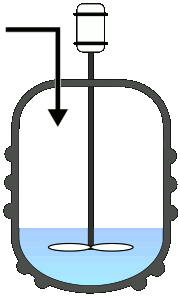

Considerações Iniciais
>
- Processo Isotérmico
>
-Sistema homogêneo
>
-Parâmetros Concentrados
>
-Reator Descontínuo Alimentado
>
- Sem saídas e com entrada de substrato
>
- Densidade é constante
>
- Substrato é consumido para gerar biomassa


# Modelo da obtenção de xilitol, a partir do hidrolisado hemicelulósico do bagaço de cana-de-açúcar. 

$$ \frac{dV}{dt} = F $$
>
$$ \frac{dX}{dt} = \mu_x \cdot X - \frac{F}{V} \cdot X $$
>
$$ \frac{dS}{dt} = \frac{F}{V} \cdot (S_F - S) - \frac{1}{Y_{X/S}} \cdot \mu_x \cdot X $$
>
$$ \frac{dP}{dt} = \biggr(\frac{1}{Y_{P/X}}\biggr) \cdot \mu_x \cdot X - \frac{F}{V} \cdot P $$

# Modelo cinético de Contois e Fujimoto (1959) e Aiba (1968).

$$ \mu_x =  \frac{\mu_m S}{K_s  X + S} $$
>
$$ \mu_x =  \frac{\mu_m S}{K_s  + S} \cdot e^{-K_pP} $$

# Simulação de uma fermentação em reator batelada alimentada

In [ ]:
#Preparação do ambiente de programação:

#Inserção das bibliotecas

import numpy as np
import pandas as pd
from google.colab import drive
import scipy.integrate as integrate
from scipy import optimize
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error




In [ ]:
# Para manter montada a pasta do Google Drive no COLAB
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/PFG_DelCampo/'
dados = pd.read_csv(path+'dados_alimentado_20.csv', sep=';')
dados.shape

(18, 6)

In [ ]:
dados

,t_h,X,G,S,A,P
0,0.0,0.5,2,45,2.8,0.0
1,25.0,6.6,0,26,4.2,13.3
2,26.8,6.8,0,25,3.5,13.0
3,28.3,6.3,0,26,3.5,13.9
4,29.6,6.1,0,25,3.4,13.2
5,30.9,5.9,0,26,3.7,14.3
6,32.0,5.5,0,24,3.4,12.8
7,33.2,5.3,0,24,2.8,12.2
8,34.2,5.1,0,26,3.6,13.8
9,35.2,5.0,0,26,3.5,13.6


# Condições Iniciais

In [ ]:
V0 =  2.5     #L
X0 =  0.5     #g/L  
S0 = 45.0     #g/L
P0 =  0.0     #g/L

In [ ]:
#Parâmetros cinéticos iniciais

# Modelo de Contois e Fujimoto (1950)
mi_max  = 0.520     #h^-1 
Ks      = 11.179    #g/L  
Yxs     = 0.591     #g/g
Ypx     = 2.526     #g/g
F       = 0.28      #L/h
S_f     = 20.0      #g/L

# Modelo de Aiba (1968)
#mi_max  = 0.485     #h^-1 
#Ks      = 7.378      #g/L  
#Yxs     = 0.589     #g/g
#Ypx     = 2.564     #g/g
#F       = 0.28      #L/h
#S_f     = 20.0      #g/L
#Kp      = 0.000001

In [ ]:
#Verificação dos parâmetros

param = [mi_max, Ks, F, Yxs, S_f, Ypx]      #Contois e Fujimoto (1950)
param

#param = [mi_max, Ks, F, Yxs, S_f, Ypx, Kp] #Aiba (1968)
#param

[0.52, 11.179, 0.28, 0.591, 20.0, 2.526]

In [ ]:
def f_edo(t, y, param):
  V = y[0]
  X = y[1]
  S = y[2]
  P = y[3]
  #
  mi_max     = param[0]
  Ks         = param[1]
  F          = param[2]
  Yxs        = param[3]
  S_f        = param[4]
  Ypx        = param[5]
  #Kp         = param[6] 
  #
  mi = mi_max * S / (Ks*X + S) #Contois e Fujimoto (1950)
  #mi = mi_max * S / (Ks*X + S)*np.exp(-Kp*P) #Aiba (1968)
  #
  if(t < 25.0):
    F = 0.0
  elif((t >= 25.0)&(t <= 37.7)):
    t_int = t - 25.0
    a = ((mi_max*X0*V0)/(Yxs*(S0-S_f)))
    b = mi_max 
    F = a*np.exp(b*t_int)
  elif(t > 37.7):
    F = 0.0
  #
  dV_dt = F
  dX_dt = mi*X - (F/V)*X
  dS_dt = (-1/Yxs)*mi + ((S_f - S)*(F/V))
  dP_dt = (1/Ypx)*mi*X - (P*(F/V))
  #
  dydt = np.array([dV_dt, dX_dt, dS_dt, dP_dt])
  return dydt

In [ ]:
y0 = np.array([V0, X0, S0, P0])
f_edo(0, y0, param)

array([ 0.        ,  0.23127329, -0.78265072,  0.09155712])

In [ ]:
t_sim  = 100.0 #h
t_span = (0, t_sim)

In [ ]:
t_res = dados.t_h.to_numpy()
t_res

array([ 0. , 25. , 26.8, 28.3, 29.6, 30.9, 32. , 33.2, 34.2, 35.2, 36.2,
       37.1, 37.7, 41. , 44. , 47. , 54. , 76.5])

In [ ]:
import scipy.integrate as integrate

In [ ]:
sol = integrate.solve_ivp(f_edo, t_span, y0, method='RK45',
                          t_eval = t_res, args = (param,), 
                          atol = 1.0e-6)
sol 

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 146
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0. , 25. , 26.8, 28.3, 29.6, 30.9, 32. , 33.2, 34.2, 35.2, 36.2,
       37.1, 37.7, 41. , 44. , 47. , 54. , 76.5])
 t_events: None
        y: array([[ 2.5       ,  2.48934807,  2.57745045,  2.83719156,  3.29321608,
         4.18433554,  5.58989158,  8.38088243, 12.48460572, 19.38339159,
        30.98965761, 48.07178472, 60.263403  , 59.89370659, 59.89370659,
        59.89370659, 59.89370659, 59.89370659],
       [ 0.5       , 31.92009161, 33.62513491, 32.83312158, 30.05892949,
        25.18834343, 20.00961286, 14.39926736, 10.44759073,  7.41817606,
         5.24668379,  3.8780695 ,  3.42806443,  5.62295325,  7.744566  ,
         9.93146008, 15.13216166, 31.81495327],
       [45.        , 38.05631886, 37.30033728, 35.64500986, 33.39099521,
        30.44155813, 27.73124225, 25.0520344 , 23.28296337, 21.9

In [ ]:
dados['X_est'] = sol.y[1]
dados['S_est'] = sol.y[2]
dados['P_est'] = sol.y[3]

In [ ]:
dados

,t_h,X,G,S,A,P,X_est,S_est,P_est
0,0.0,0.5,2,45,2.8,0.0,0.500000,45.000000,0.000000
1,25.0,6.6,0,26,4.2,13.3,31.920092,38.056319,12.437781
2,26.8,6.8,0,25,3.5,13.0,33.625135,37.300337,13.119531
3,28.3,6.3,0,26,3.5,13.9,32.833122,35.645010,12.823136
4,29.6,6.1,0,25,3.4,13.2,30.058929,33.390995,11.749027
5,30.9,5.9,0,26,3.7,14.3,25.188343,30.441558,9.853000
6,32.0,5.5,0,24,3.4,12.8,20.009613,27.731242,7.832640
7,33.2,5.3,0,24,2.8,12.2,14.399267,25.052034,5.641172
8,34.2,5.1,0,26,3.6,13.8,10.447591,23.282963,4.096253
9,35.2,5.0,0,26,3.5,13.6,7.418176,21.980098,2.911112


In [ ]:
res_X = dados.X - dados.X_est
res_S = dados.S - dados.S_est
res_P = dados.P - dados.P_est

In [ ]:
SDQ_X = (res_X**2).sum()
SDQ_S = (res_S**2).sum()
SDQ_P = (res_P**2).sum()
SDQ = SDQ_X + SDQ_S + SDQ_P
SDQ

7414.454159816025

In [ ]:
ppe = [mi_max, Ks, F, Yxs, S_f, Ypx] 
ppe.append(y0[1])
ppe
#
#ppe = [mi_max, Ks, F, Yxs, S_f, Ypx, Kp]
#ppe.append(y0[1])
#ppe

[0.52, 11.179, 0.28, 0.591, 20.0, 2.526, 0.5]

In [ ]:
ppe[0:6]
#ppe[0:7]

[0.52, 11.179, 0.28, 0.591, 20.0, 2.526]

In [ ]:
def f_obj(par, y0, dados):
  t_res = dados.t_h.to_numpy()
  #
  sol = integrate.solve_ivp(f_edo, t_span, y0, method='LSODA',
                          t_eval = t_res, args = (par,), 
                          atol = 1.0e-6)
  dados['X_est'] = sol.y[1]
  dados['S_est'] = sol.y[2]
  dados['P_est'] = sol.y[3]
  res_X = dados.X - dados.X_est
  res_S = dados.S - dados.S_est
  res_P = dados.P - dados.P_est
  SDQ_X = (res_X**2).sum()
  SDQ_S = (res_S**2).sum()
  SDQ_P = (res_P**2).sum()
  SDQ   = SDQ_X + SDQ_S + SDQ_P
  return SDQ

In [ ]:
f_obj(ppe, y0, dados)

7267.498958624695

In [ ]:
result_otim = optimize.minimize(f_obj, ppe, method="Nelder-Mead", 
                                args=(y0, dados), 
                                options={'maxiter':2000})
result_otim

 final_simplex: (array([[ 0.10763337, 25.90378729,  0.06795779,  0.07978942, 27.27653679,
         0.1022979 ,  1.33199377],
       [ 0.10763337, 25.90378729,  0.06795779,  0.07978942, 27.27653679,
         0.1022979 ,  1.33199377],
       [ 0.10763337, 25.90378729,  0.06795779,  0.07978942, 27.27653679,
         0.1022979 ,  1.33199377],
       [ 0.10763337, 25.90378729,  0.06795779,  0.07978942, 27.27653679,
         0.1022979 ,  1.33199377],
       [ 0.10763337, 25.90378729,  0.06795779,  0.07978942, 27.27653679,
         0.1022979 ,  1.33199377],
       [ 0.10763337, 25.90378729,  0.06795779,  0.07978942, 27.27653679,
         0.1022979 ,  1.33199377],
       [ 0.10763337, 25.90378729,  0.06795779,  0.07978942, 27.27653679,
         0.1022979 ,  1.33199377],
       [ 0.10763337, 25.90378729,  0.06795779,  0.07978942, 27.27653679,
         0.1022979 ,  1.33199377]]), array([484.69516284, 484.69516284, 484.69516284, 484.69516284,
       484.69516284, 484.75651794, 484.75651794, 484.7

In [ ]:
param = [mi_max, Ks, F, Yxs, S_f, Ypx]


In [ ]:
par_est = result_otim.x
par_est

array([ 0.10763337, 25.90378729,  0.06795779,  0.07978942, 27.27653679,
        0.1022979 ,  1.33199377])

In [ ]:
dados

,t_h,X,G,S,A,P,X_est,S_est,P_est
0,0.0,0.5,2,45,2.8,0.0,0.500000,45.000000,0.000000
1,25.0,6.6,0,26,4.2,13.3,2.100341,26.975560,15.656965
2,26.8,6.8,0,25,3.5,13.0,2.081746,26.226548,15.816653
3,28.3,6.3,0,26,3.5,13.9,2.051262,25.656925,15.814310
4,29.6,6.1,0,25,3.4,13.2,2.014806,25.203819,15.718300
5,30.9,5.9,0,26,3.7,14.3,1.969391,24.787981,15.537686
6,32.0,5.5,0,24,3.4,12.8,1.924839,24.464654,15.324825
7,33.2,5.3,0,24,2.8,12.2,1.870592,24.141366,15.034997
8,34.2,5.1,0,26,3.6,13.8,1.821556,23.894237,14.752843
9,35.2,5.0,0,26,3.5,13.6,1.769638,23.666213,14.438604


In [ ]:
#Rendimento do processo por Contois e Fujimoto
yps = 34.564075/(45-12.655491)
yps

1.0686226524570215

In [ ]:
#Rendimento do processo por Aiba
#yps = 37.857001/ (45-13.517095)
#yps

1.202462129844752

In [ ]:
#Produtividade do processo por Contois e Fujimoto
Q = 34.564075/76.5
Q

0.4518179738562092

In [ ]:
#Produtividade por Aiba
#Q = 37.857001/76.5
#Q

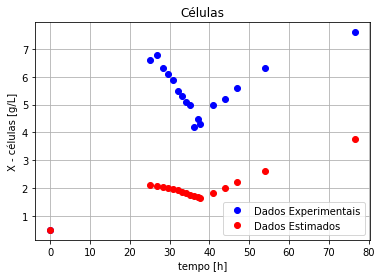

In [ ]:
fig2, ax2 = plt.subplots()
ax2.plot(dados.t_h, dados.X    , 'bo', label='Dados Experimentais')
ax2.plot(dados.t_h, dados.X_est, 'bo', label='Dados Estimados', color='red')
# Adicionando texto nos eixos - descrição
ax2.set_xlabel('tempo [h]')
ax2.set_ylabel('X - células [g/L]')
# Adicionando título para a figura
ax2.set_title('Células')
# Adicionando uma legenda
ax2.legend()
ax2.grid()

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(dados.X_est, dados.X)
r2

-33.73984932515655

In [ ]:
err = mean_absolute_error(dados.X, dados.X_est)
err

3.345532926063731

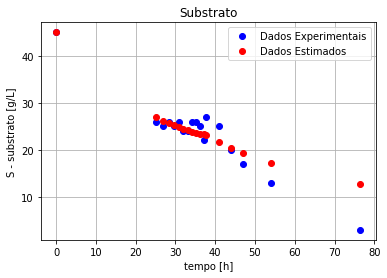

In [ ]:
fig3, ax3 = plt.subplots()
ax3.plot(dados.t_h, dados.S    , 'bo', label='Dados Experimentais')
ax3.plot(dados.t_h, dados.S_est, 'bo', label='Dados Estimados', color='red')
# Adicionando texto nos eixos - descrição
ax3.set_xlabel('tempo [h]')
ax3.set_ylabel('S - substrato [g/L]')
# Adicionando título para a figura
ax3.set_title('Substrato')
# Adicionando uma legenda
ax3.legend()
ax3.grid()

In [ ]:
r2 = r2_score(dados.S, dados.S_est)
r2

0.8536316388090778

In [ ]:
err = mean_absolute_error(dados.S, dados.S_est)
err

1.9884428927159794

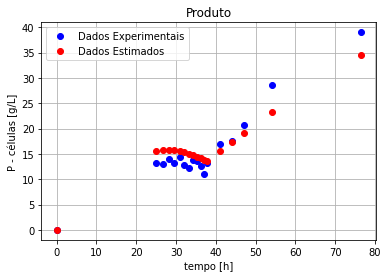

In [ ]:
fig4, ax4 = plt.subplots()
ax4.plot(dados.t_h, dados.P    , 'bo', label='Dados Experimentais')
ax4.plot(dados.t_h, dados.P_est, 'bo', label='Dados Estimados', color='red')
# Adicionando texto nos eixos - descrição
ax4.set_xlabel('tempo [h]')
ax4.set_ylabel('P - células [g/L]')
# Adicionando título para a figura
ax4.set_title('Produto')
# Adicionando uma legenda
ax4.legend()
ax4.grid()

In [ ]:
r2 = r2_score(dados.P,dados.P_est)
r2

0.9033662049235209

In [ ]:
err = mean_absolute_error(dados.P,dados.P_est)
err

1.96695501939467